In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics


In [2]:
# pickle ファイルから読み込み
train_pkl = pd.read_pickle('../001/train.pk1')

In [3]:
train_pkl.shape

(850, 11)

In [4]:
# 年齢(Age)、性別(Gender_Male)は削除
train_pkl.drop(['Gender_Male'], axis=1, inplace=True)

In [5]:
train_pkl.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,0.787109,0.150513,220.178696,13.467617,21.729246,6.816406,3.111328,1.006836,0
1,69,1.003906,0.195679,221.218414,51.033463,64.752319,6.890625,3.050781,0.751465,1
2,65,0.657227,0.081299,320.770538,12.625011,30.613180,5.949219,2.488281,0.774902,0
3,65,0.906738,0.214233,369.278168,34.347599,54.510086,6.968750,3.613281,0.988281,1
4,22,1.735352,0.197754,222.782028,20.572891,170.010178,5.835938,3.068359,1.026367,0


In [6]:
train_pk2 = train_pkl.copy()
train_pkl.shape

(850, 10)

In [7]:
# I_Bill間接ビルビリンを追加
train_pkl['I_Bill'] = train_pkl['T_Bil'] - train_pkl['D_Bil']
# 直接ビルビリンを追加
train_pkl['P_Bill'] = train_pkl['D_Bil'] / train_pkl['T_Bil']


In [8]:
disease_bk = train_pkl.disease.values

In [9]:
train_pkl.drop('disease', axis=1, inplace=True)

In [10]:
train_pkl['disease'] = disease_bk

In [11]:
train_pkl.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,I_Bill,P_Bill,disease
0,59,0.787109,0.150513,220.178696,13.467617,21.729246,6.816406,3.111328,1.006836,0.636719,0.191162,0
1,69,1.003906,0.195679,221.218414,51.033463,64.752319,6.890625,3.050781,0.751465,0.808105,0.194946,1
2,65,0.657227,0.081299,320.770538,12.625011,30.613180,5.949219,2.488281,0.774902,0.576172,0.123718,0
3,65,0.906738,0.214233,369.278168,34.347599,54.510086,6.968750,3.613281,0.988281,0.692383,0.236328,1
4,22,1.735352,0.197754,222.782028,20.572891,170.010178,5.835938,3.068359,1.026367,1.537109,0.113953,0


## 訓練データとテストデータに分割

In [12]:
# 訓練とテストデータに分割
train, test = train_test_split(train_pkl, test_size=0.2, random_state=42)

In [13]:
# ターゲットと特徴量の分割
train_X = train.iloc[:, :-1]
train_y = train.disease

In [14]:
# ターゲットと特徴量の分割
test_X = test.iloc[:, :-1]
test_y = test.disease

In [15]:
# LightGBMのモデルへデータセットの初期化セット
train_data = lgb.Dataset(train_X, label=train_y)
test_data =  lgb.Dataset(test_X, label=test_y, reference=train_data)

## LightGBM

In [16]:
# パラメータ
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'verbose': 2
}

In [17]:
# 訓練
gbm = lgb.train(
    params,
    train_data,
    valid_sets=test_data,
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100
)


Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.273027
[100]	valid_0's binary_logloss: 0.326607
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.262467


In [18]:
# scikit-learn経由で
gbm2 = lgb.LGBMClassifier(objective='binary', n_estimators=1000, seed=42)

In [19]:
gbm2.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose=50)

[50]	valid_0's binary_logloss: 0.273027
[100]	valid_0's binary_logloss: 0.326607
[150]	valid_0's binary_logloss: 0.406345
[200]	valid_0's binary_logloss: 0.482021
[250]	valid_0's binary_logloss: 0.563723
[300]	valid_0's binary_logloss: 0.640278
[350]	valid_0's binary_logloss: 0.676695
[400]	valid_0's binary_logloss: 0.694099
[450]	valid_0's binary_logloss: 0.709107
[500]	valid_0's binary_logloss: 0.718437
[550]	valid_0's binary_logloss: 0.725316
[600]	valid_0's binary_logloss: 0.73258
[650]	valid_0's binary_logloss: 0.737443
[700]	valid_0's binary_logloss: 0.7427
[750]	valid_0's binary_logloss: 0.747128
[800]	valid_0's binary_logloss: 0.750738
[850]	valid_0's binary_logloss: 0.754729
[900]	valid_0's binary_logloss: 0.756358
[950]	valid_0's binary_logloss: 0.758126
[1000]	valid_0's binary_logloss: 0.759583


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [20]:
preds = gbm2.predict(test_X, num_iteration=gbm.best_iteration)

In [21]:
preds = gbm2.predict_proba(test_X)

In [22]:
y_pred = np.where(preds < 0.5, 0, 1)

In [23]:
pred_y = np.argmax(y_pred, axis=1)

In [24]:
confusion_matrix(test_y, pred_y)

array([[88,  5],
       [20, 57]], dtype=int64)

In [31]:
test_y.sum(), pred_y.sum()

(77, 62)

In [25]:
accuracy_score(test_y, pred_y)

0.8529411764705882

In [26]:
roc_auc_score(test_y, pred_y)

0.8432481496997626

In [27]:
fpr, tpr, thr = roc_curve(test_y, pred_y)

In [28]:
auc = metrics.auc(fpr, tpr)

In [29]:
auc

0.8432481496997626

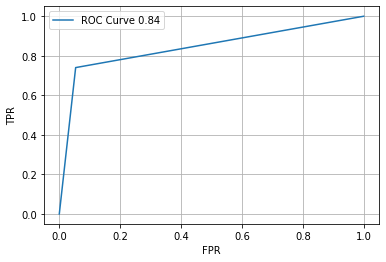

In [30]:
plt.plot(fpr, tpr, label="ROC Curve %.2f"%auc)
plt.legend()
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.grid()
plt.show()

## 検証データで実行

In [ ]:
# 検証データ読み込み
valid = pd.read_pickle('./test.pk2')

In [ ]:
# ID の保存
# valid_pass = valid.id.values

In [ ]:
# valid_X = valid.iloc[:, 1:]
valid_X = valid.copy()

In [ ]:
valid_X.shape, train_X.shape

In [ ]:
pred_valid_y = gbm2.predict(valid_X)

In [ ]:
pred_valid_y.shape

In [ ]:
preds = gbm2.predict_proba(valid_X)

In [ ]:
y_pred = np.where(preds < 0.5, 0, 1)

In [ ]:
pred_y = np.argmax(y_pred, axis=1)

In [ ]:
# type(valid_pass), type(pred_valid_y)

In [ ]:
result_df = pd.DataFrame(pred_y)

In [ ]:
result_df.to_csv("./LGBM_1.csv", header=False)

In [ ]:
result_df